## Predicting Vehicle Type for Households in California

11/2/2017

Provenance of the Data: California Housing Travel Survey

## Table of Contents

### [0. Imported Modules](#Imported-Modules)
### [1. Load Data](#Load-Data)
### [1.5. Join Data](#Join-Data)
### [2. Predicting Vehicle Type](#Predicting-Vehicle-Type)
### [3. Transform and Preprocess Data](#Transform-and-Preprocess-Data)
### [4. Descriptive Statistics](#Descriptive-Statistics)
### [5. Build Preprocessed Dataset](#Build-Preprocessed-Dataset)
### [6. Feature Extraction](#Feature-Extraction)
### [7. Build Features](#Build-Features)
### [8. Baseline Models](#Baseline-Models)
### [9. Error Analysis](#Error-Analysis)
### [10. Change the Baseline](#Change-the-Baseline)
### [11. Decision Trees](#Decision-Trees)
### [12. Ensemble Methods](#Ensemble-Methods)
### [13. Summary](#Summary)

### Imported Modules
[Top](#Table-of-Contents)

In [2]:
# Tables, Queries, and Stats
import pandas as pd
import numpy as np

# Feature Selection
from sklearn.feature_selection import SelectKBest, chi2

# Pipeline
from sklearn.pipeline import Pipeline

# Plotting
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

# Data Partitioning
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier

# Decision Tree Model and Plotting
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

# Ensemble Methods
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

# Error Analysis
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Computational Performance
import time

# OS, path, system access
import os
import os.path

### Load Data
[Top](#Table-of-Contents)

### There are 9 different Survey Tables in the CHTS

In [3]:
def get_tables_in(data_dir):
    tables_caltrans = [files for root, dirs, files in os.walk(os.getcwd() +\
                                                    data_dir, topdown=True, followlinks=False)][0]
    return tables_caltrans

In [4]:
caltrans_tables = get_tables_in('/caltrans_full_survey/')

In [5]:
def make_dfs_from_files(file_list, table_type, data_dir='caltrans_full_survey/'):
    ''' Create Pandas DataFrames from the list of data files in CHTS. The 
    table_type signifies the group that the data belongs to.
    Possible groups: Surveys, Vehicles, Wearables
    '''
    start = time.time()
    subset_tables = {}
    if table_type == 'survey tables':
        subset = [file for file in file_list if file.startswith('survey_')]
    if table_type == 'vehicle tables':
        subset = [file for file in file_list if file.startswith('v_')]
    if table_type == 'wearable tables':
        subset = [file for file in file_list if file.startswith('w_')]
    for file in subset:
        df = pd.read_csv(data_dir + file, low_memory=False)
        subset_tables[file] = df
    end = time.time()
    print('Loading the {} took {:.3f} seconds.'.format(table_type, end - start))
    return subset_tables

In [6]:
survey_tables = make_dfs_from_files(caltrans_tables, table_type='survey tables')
vehicle_tables = make_dfs_from_files(caltrans_tables, table_type='vehicle tables')
wearable_tables = make_dfs_from_files(caltrans_tables, table_type='wearable tables')

Loading the survey tables took 3.270 seconds.
Loading the vehicle tables took 0.134 seconds.
Loading the wearable tables took 2.045 seconds.


### From the caltrans_data_dictionary, I know the following tables have veh_type defined:
 - survey_vehicles
 - v_obd_vehicles
 - gps_obd_vehicles

#### Survey of Households, Survey Tables, California Travel Housing Survey

I will begin the exploration with survey of households and survey of vehicles

In [7]:
survey_tables.keys()

dict_keys(['survey_households.csv', 'survey_longtrips.csv', 'survey_longtrips_v02.csv', 'survey_vehicles.csv', 'survey_households_wgts.csv', 'survey_person_wgts.csv'])

In [8]:
df_survey_households = survey_tables['survey_households.csv']

In [9]:
df_survey_vehicles = survey_tables['survey_vehicles.csv']

In [10]:
#loading the persons and places datasets

df_survey_places = pd.read_csv('../caltrans_full_survey/survey_place.csv')
df_survey_persons = pd.read_csv('../caltrans_full_survey/survey_person.csv')


/Applications/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (22,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Applications/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (9,46,50,51,102,105,120) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
print(df_survey_households.shape)

(42426, 83)


In [12]:
print(df_survey_persons.shape)

(109113, 152)


In [13]:
print(df_survey_vehicles.shape)

(79011, 38)


### Null Counts in the data

**Survey of Households**

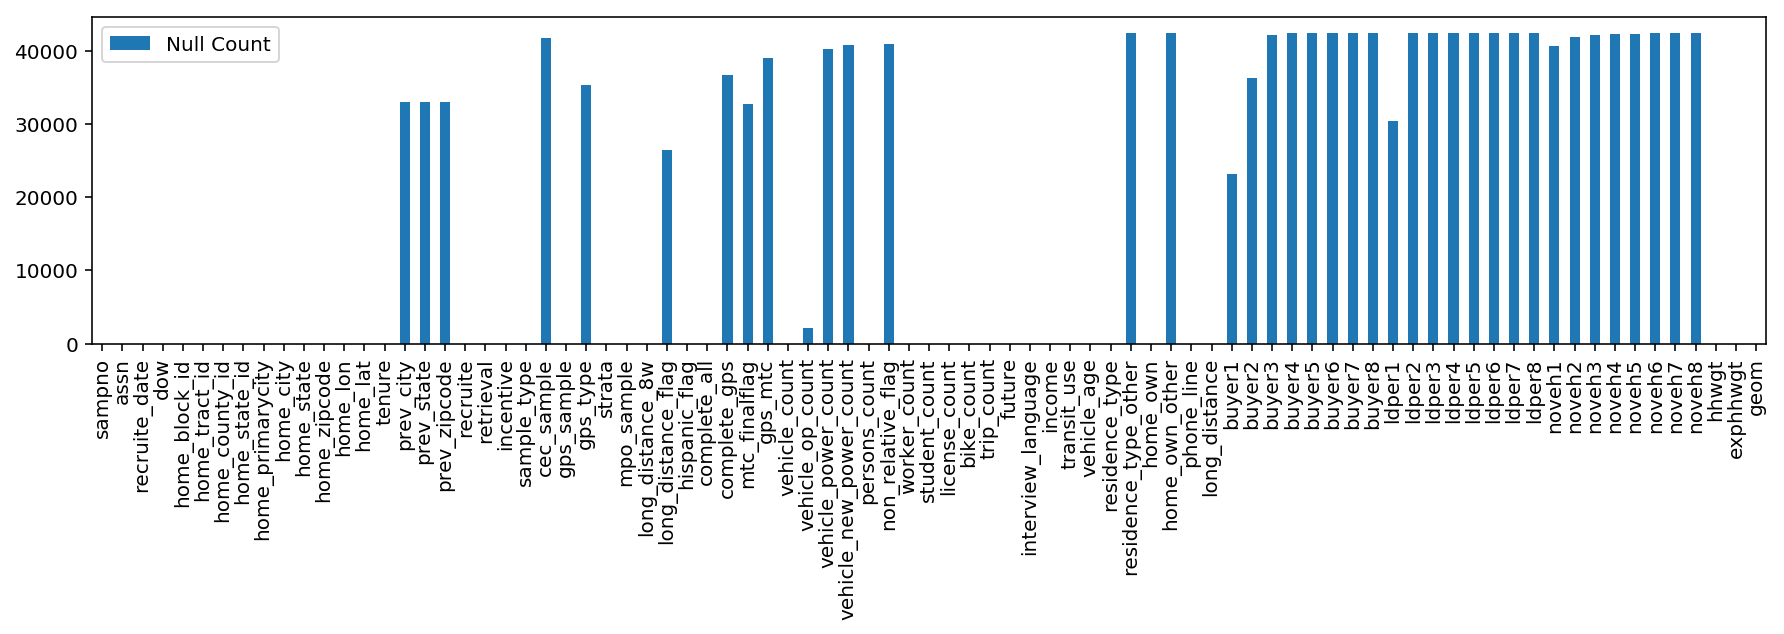

In [12]:
pd.DataFrame(df_survey_households.isnull().sum(), columns=['Null Count']).plot(kind='bar', figsize=(15,3));

In [11]:
df_survey_households.shape

(42426, 83)

**Survey of Vehicles**

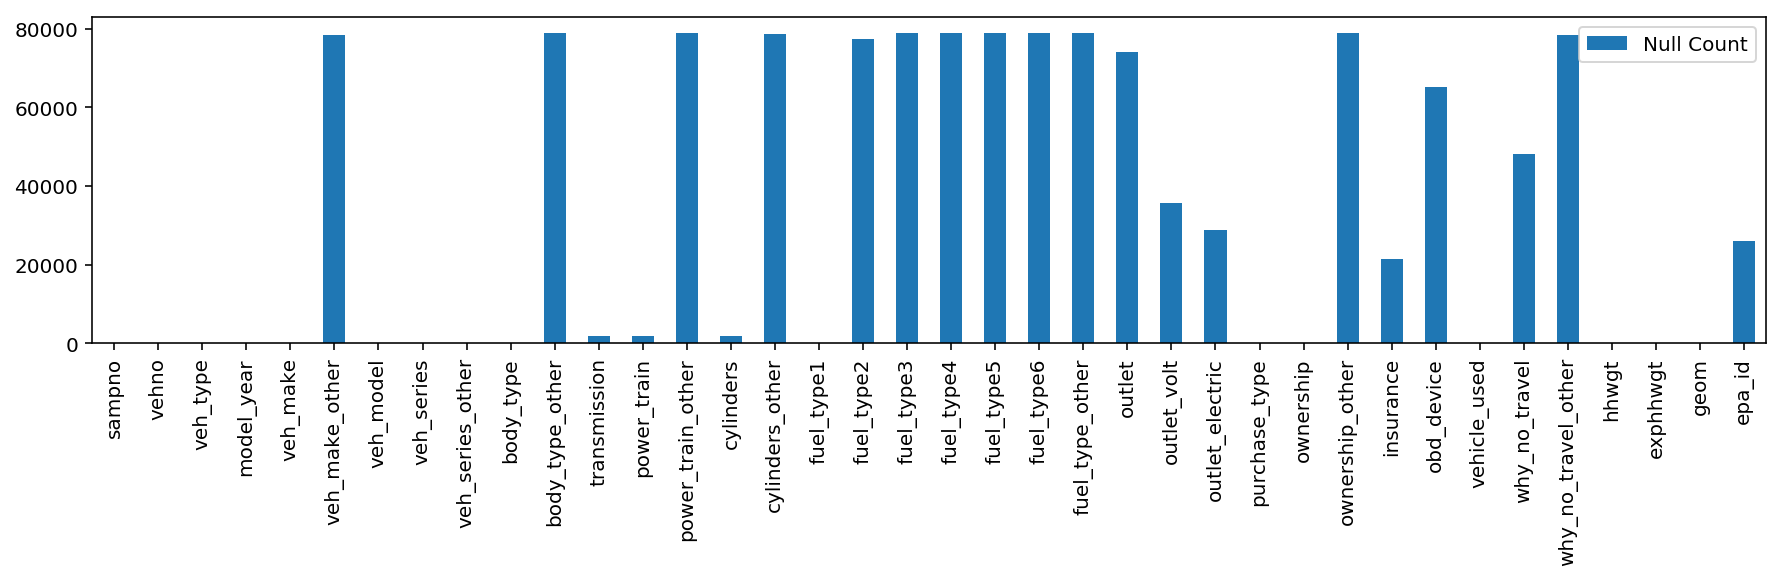

In [10]:
pd.DataFrame(df_survey_vehicles.isnull().sum(), columns=['Null Count']).plot(kind='bar', figsize=(15,3));

In [12]:
df_survey_vehicles.shape

(79011, 38)

**Survey of Persons **

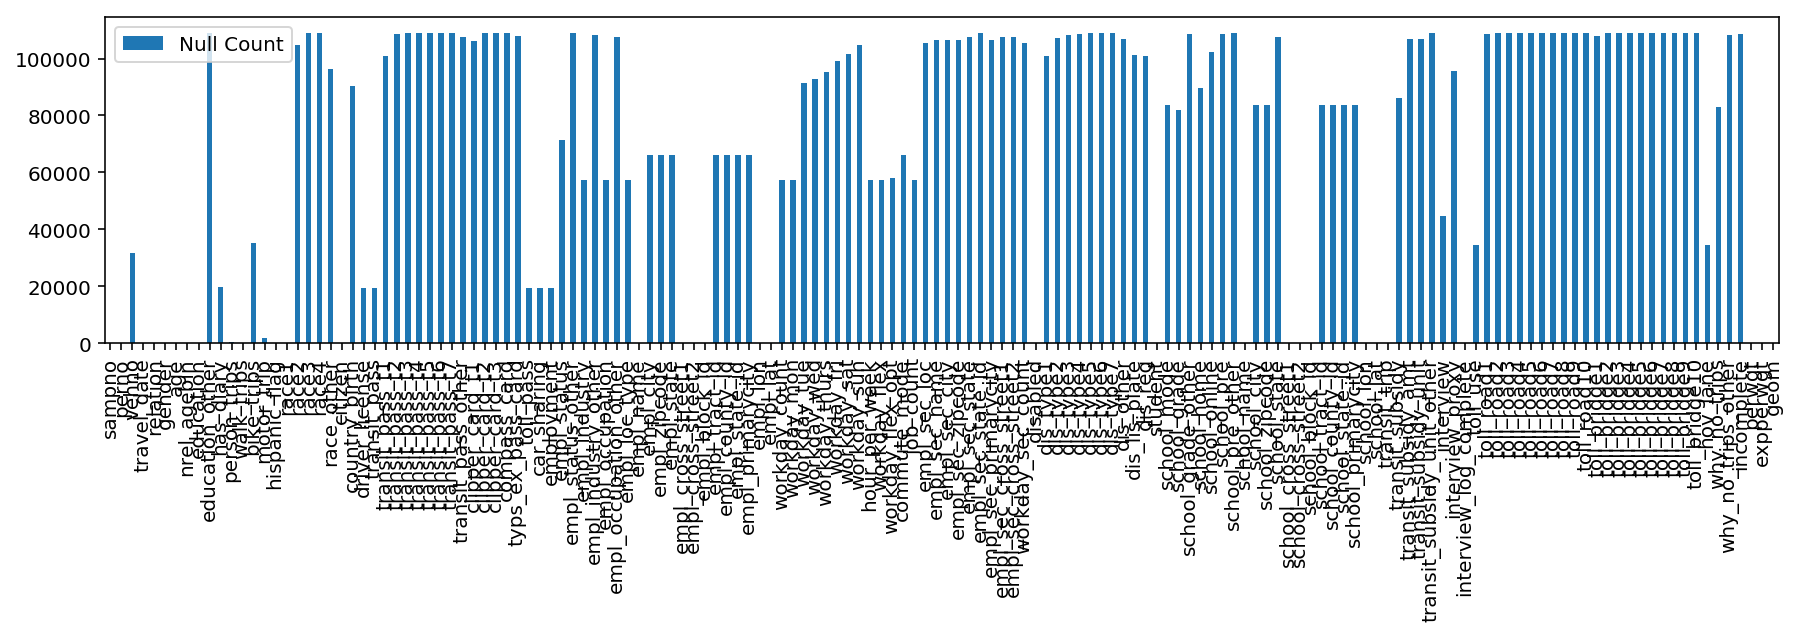

In [13]:
pd.DataFrame(df_survey_persons.isnull().sum(), columns=['Null Count']).plot(kind='bar', figsize=(15,3));

In [18]:
df_survey_persons.shape

(109113, 152)

**Survey of Places**

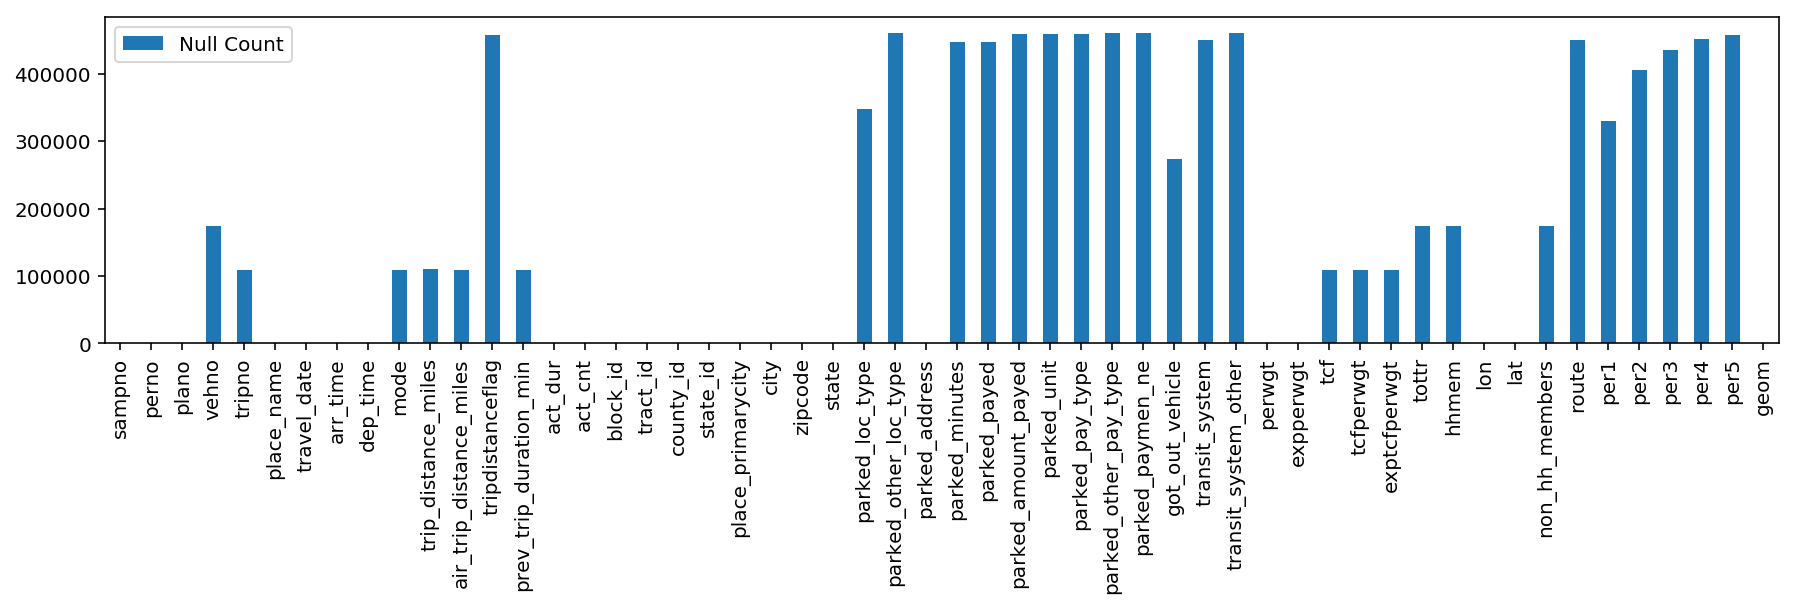

In [14]:
pd.DataFrame(df_survey_places.isnull().sum(), columns=['Null Count']).plot(kind='bar', figsize=(15,3));

In [19]:
df_survey_places.shape

(460524, 54)

### Join Data
[Top](#Table-of-Contents)

#### I will join two tables below, first checking for duplicate household numbers

In [20]:
len(df_survey_households['sampno'].unique()) == len(df_survey_households['sampno'])

True

So there are no duplicate entries in the households table.

In [21]:
len(df_survey_vehicles['sampno'].unique()) == len(df_survey_vehicles['sampno'])

False

In [22]:
len(df_survey_vehicles['sampno'].unique())

39973

In [23]:
sur_veh_sampno_dups = len(df_survey_vehicles['sampno']) - len(df_survey_vehicles['sampno'].unique())
sur_veh_sampno_dups

39038

Thus, there are 39,038 duplicate household entries out of the 79,011 entries for the survey_vehicles table. 

In [24]:
len(df_survey_persons['sampno'].unique()) == len(df_survey_persons['sampno'])

False

In [25]:
len(df_survey_persons['sampno'].unique())

42431

In [27]:
sur_persons_sampno_dups = len(df_survey_persons['sampno']) - len(df_survey_persons['sampno'].unique())
sur_persons_sampno_dups

66682

Thus, there are 66,682 duplicate household entries out of the 109,113 entries for the survey_persons table. 

In [29]:
len(df_survey_places['sampno'].unique()) == len(df_survey_places['sampno'])

False

In [30]:
len(df_survey_places['sampno'].unique())

42431

In [31]:
sur_places_sampno_dups = len(df_survey_places['sampno']) - len(df_survey_places['sampno'].unique())
sur_places_sampno_dups

418093

Thus, there are 41,8093 duplicate household entries out of the 460,524 entries for the survey_places table. 

**I will do a left join and keep the extra entries for now**

In [37]:
df_survey_hous_veh = pd.merge(df_survey_vehicles, df_survey_households, on='sampno', how='left')

In [38]:
df_survey_hous_veh.shape

(79011, 120)

In [19]:
len(df_survey_hous_veh['sampno'].unique())

39973

This is the same value as before, so the merge was successful.

In [20]:
df_survey_hous_veh.head()

,sampno,vehno,veh_type,model_year,veh_make,veh_make_other,veh_model,veh_series,veh_series_other,body_type,...,noveh2,noveh3,noveh4,noveh5,noveh6,noveh7,noveh8,hhwgt_y,exphhwgt_y,geom_y
0,7156986,2,2,2009,51,NaN,REDACTED,REDACTED,REDACTED,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.304210,675.182099,REDACTED
1,7156986,3,2,2000,17,NaN,REDACTED,REDACTED,REDACTED,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.304210,675.182099,REDACTED
2,7157693,1,2,2012,20,NaN,REDACTED,REDACTED,REDACTED,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.606680,177.770223,REDACTED
3,7158808,1,2,2003,13,NaN,REDACTED,REDACTED,REDACTED,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.923009,270.461039,REDACTED
4,7158808,2,2,1992,13,NaN,REDACTED,REDACTED,REDACTED,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.923009,270.461039,REDACTED


The duplicates in the vehicles table make sense now because each household may have more than one car. This is the case with sampno=7156986.

### Null values in the joined dataset

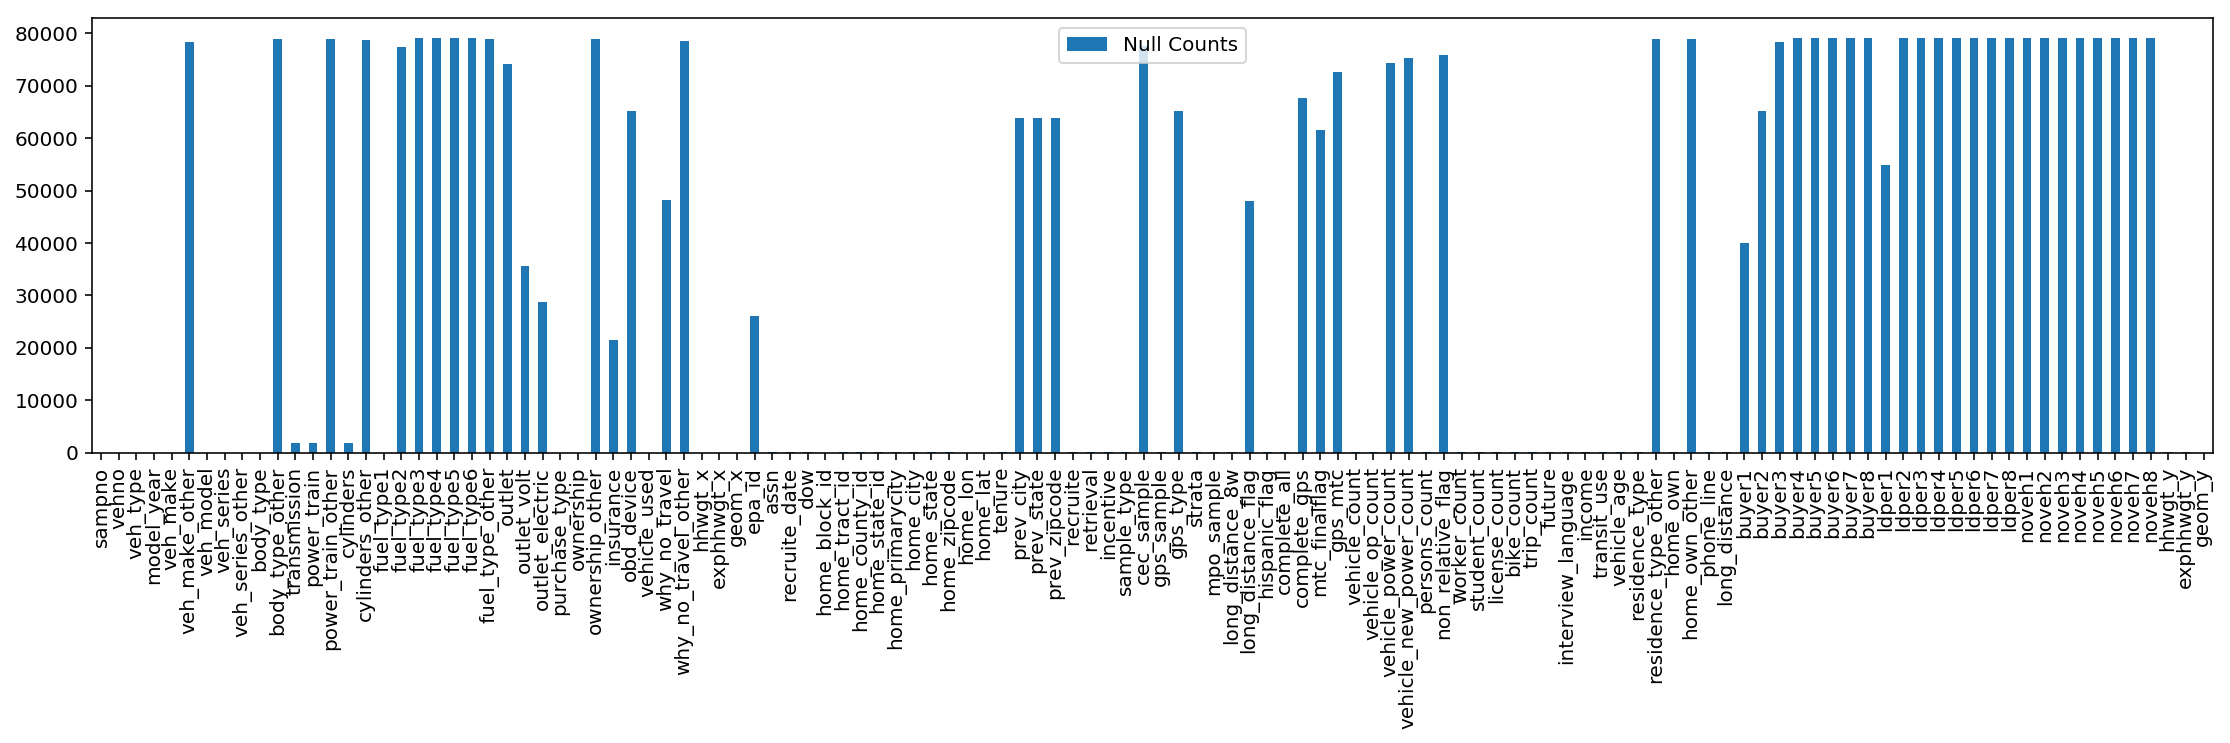

In [21]:
pd.DataFrame(df_survey_hous_veh.isnull().sum(), columns=['Null Counts']).plot(kind='bar', figsize=(19,4));

### Predicting Vehicle Type
[Top](#Table-of-Contents)

**_ We want to predict vehicle type in order to find the relationship between demographic data and vehicle preference. Our demographic data includes: Education, gender, race, age, employment status, etc._**

# Transform and Preprocess Data
[Top](#Table-of-Contents)

Let's have a brief look at the data, see if there are any categorical variables, and transform them if so.

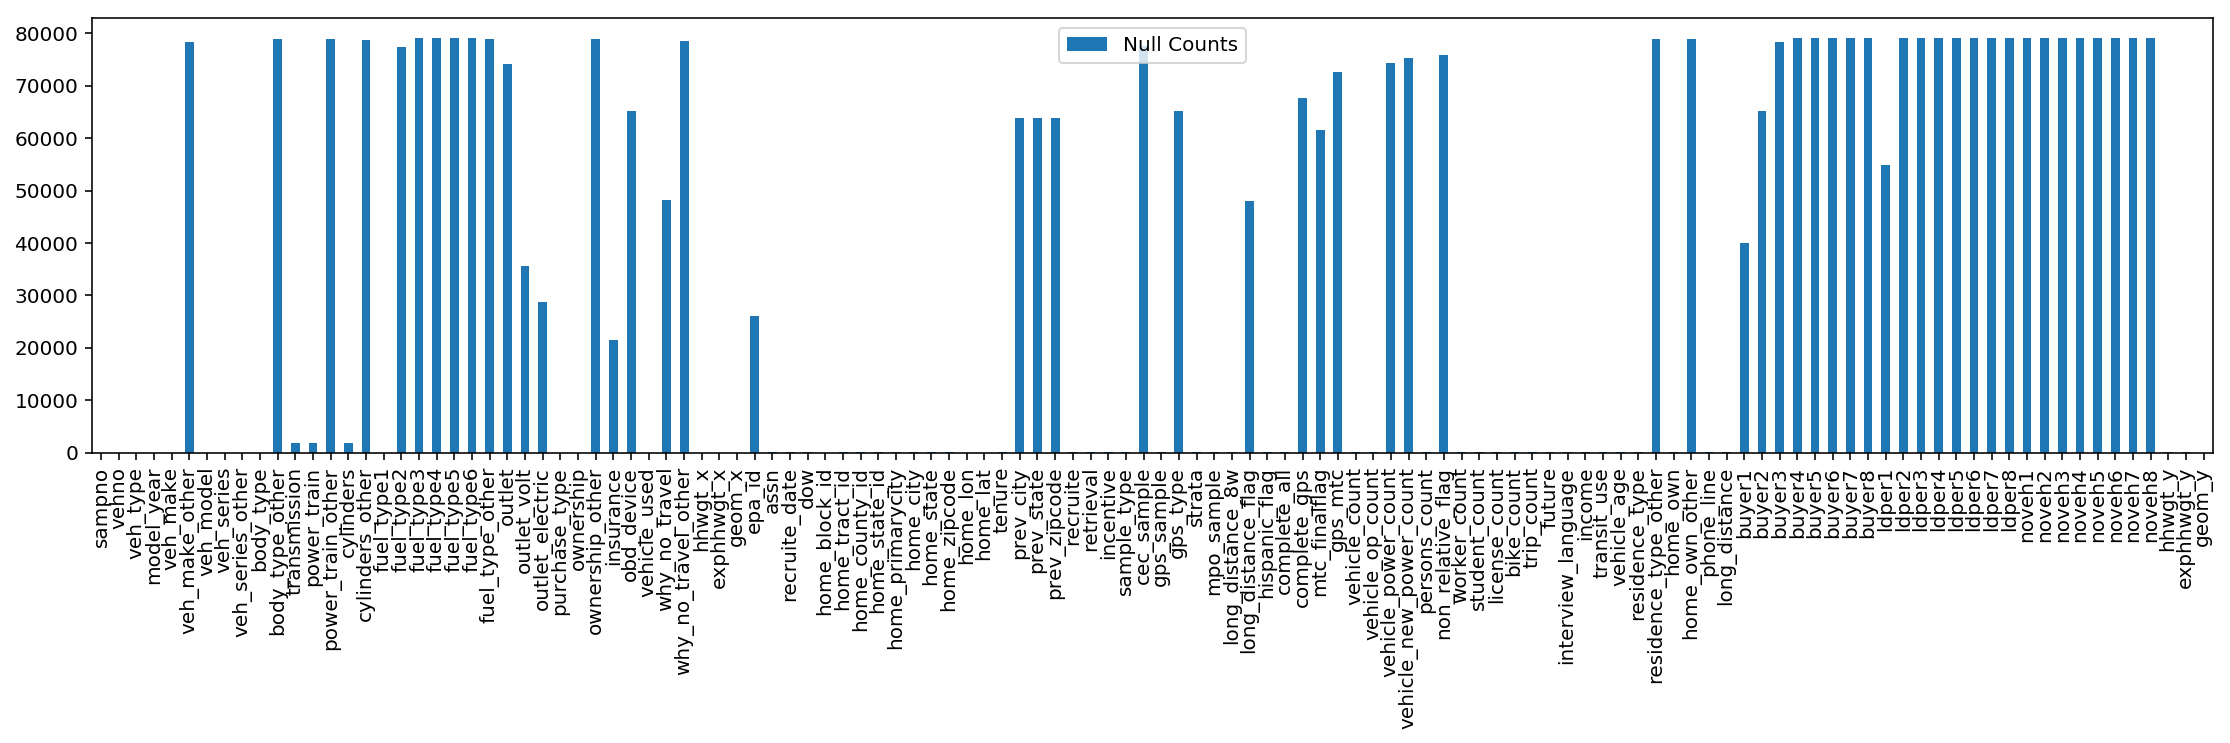

In [22]:
pd.DataFrame(df_survey_hous_veh.isnull().sum(), columns=['Null Counts']).plot(kind='bar', figsize=(19,4));

Based on the above graph, I will choose columns that don't have null values for now, and build a simple ML pipeline to predict veh_type.

In [43]:
def get_subset(df, column_names):
    ''' Return a subset of the dataframe based on the column names given.
    This will be used for quick prototyping of the entire pipeline.
    
    Parms:
        df - the original dataframe
        column_names - the column names to extract
    
    Returns:
        df_subset
    '''
    return df[column_names]

def nans_fill_zero(df):
    ''' One of many possible ways to handle any NaNs in the dataset.
    I will simply fill them with zeros.
    '''
    return df.fillna(0)

def get_bay_area(df):
    ''' 
    Get only the Bay Area housing instances 
    '''
    if 'home_county_id' not in df.columns:
        print('Error: no \'home_county_id\' column found')
        return
    else:
        df = df[df.home_county_id.isin([1, 13, 41, 55, 75, 81, 85, 95, 97])]
        return df

def remove_columns(df, name='persons_place'):
    '''
    Remove columns that may be irrelevant for a certain analysis.
    '''
    unnecessary_columns = ['recruite', 'incentive', 'sample_type', 'cec_sample', 'non_relative_flag',
                           'strata', 'mpo_sample', 'mtc_finalflag','buyer1', 'home_state_id',
                           'buyer2', 'buyer3', 'buyer4', 'buyer5', 'buyer6', 'buyer7', 'buyer8',
                           'ldper1', 'ldper2', 'ldper3', 'ldper4', 'ldper5', 'ldper6', 'ldper7',
                           'noveh3', 'noveh4', 'noveh5', 'noveh6', 'noveh7', 'noveh8', 'gps_mtc',
                           'ldper8', 'complete_all', 'complete_gps',
                           'sampno', 'hispanic_flag', 'assn', 'recruite_date', 'home_block_id',
                           'home_tract_id']
    if name=='persons_place':
        unnecessary_columns += ['hhwgt', 'exphhwgt', 'geom']
    if name=='housing_vehicle':
        unnecessary_columns += ['noveh1','noveh2','fuel_type3','fuel_type4','fuel_type5','fuel_type6']
    df = df.drop(unnecessary_columns, axis=1, inplace=False)
    #print(df.columns)
    #print(df.shape)
    return df

Notes, barriers: 
- Can't use home_lon or home_lat because they are 'REDACTED'.

#### Test Cases 
- Vehicle Type vs. Number of household workers and Number of household students

### Descriptive Statistics
[Top](#Table-of-Contents)

In [44]:
# Get Bay Area housing only
df_survey_hous_veh_ba = get_bay_area(df_survey_hous_veh)
df_survey_hous_veh_ba.shape

(17497, 120)

In [45]:
df_survey_hous_veh_ba = remove_columns(df_survey_hous_veh_ba,name='housing_vehicle')
df_survey_hous_veh_ba.shape

(17497, 74)

In [46]:
#get the types of all features in households dataset
df_survey_hous_veh_ba.head()
df_survey_hous_veh_ba.dtypes

#get the basic statistics of all features in households dataset
stats_survey_house_veh = pd.DataFrame({'mean': df_survey_hous_veh_ba.mean(), 'std': df_survey_hous_veh_ba.std(), \
                                      'min':df_survey_hous_veh_ba.min(), 'max':df_survey_hous_veh_ba.max()})
#trimmed_households.describe()
stats_survey_house_veh

,max,mean,min,std
bike_count,99,2.011945,0,3.440015
body_type,99,3.548094,1,7.495593
cylinders,99,17.248173,1,33.648750
dow,7,3.620106,1,1.703600
epa_id,37370,12828.417964,8,7202.126501
exphhwgt_x,1236.4,259.199507,8.4211,117.496756
exphhwgt_y,1236.4,259.199507,8.4211,117.496756
fuel_type1,9,1.053498,1,0.371608
fuel_type2,7,3.045369,1,0.817553
future,2,1.320112,1,0.466533


We can see that there are a few qualitative variables whose values for the basic statistics, naturally, are NaNs. We will be using these variables later in the analysis.

**Correlation Matrix**

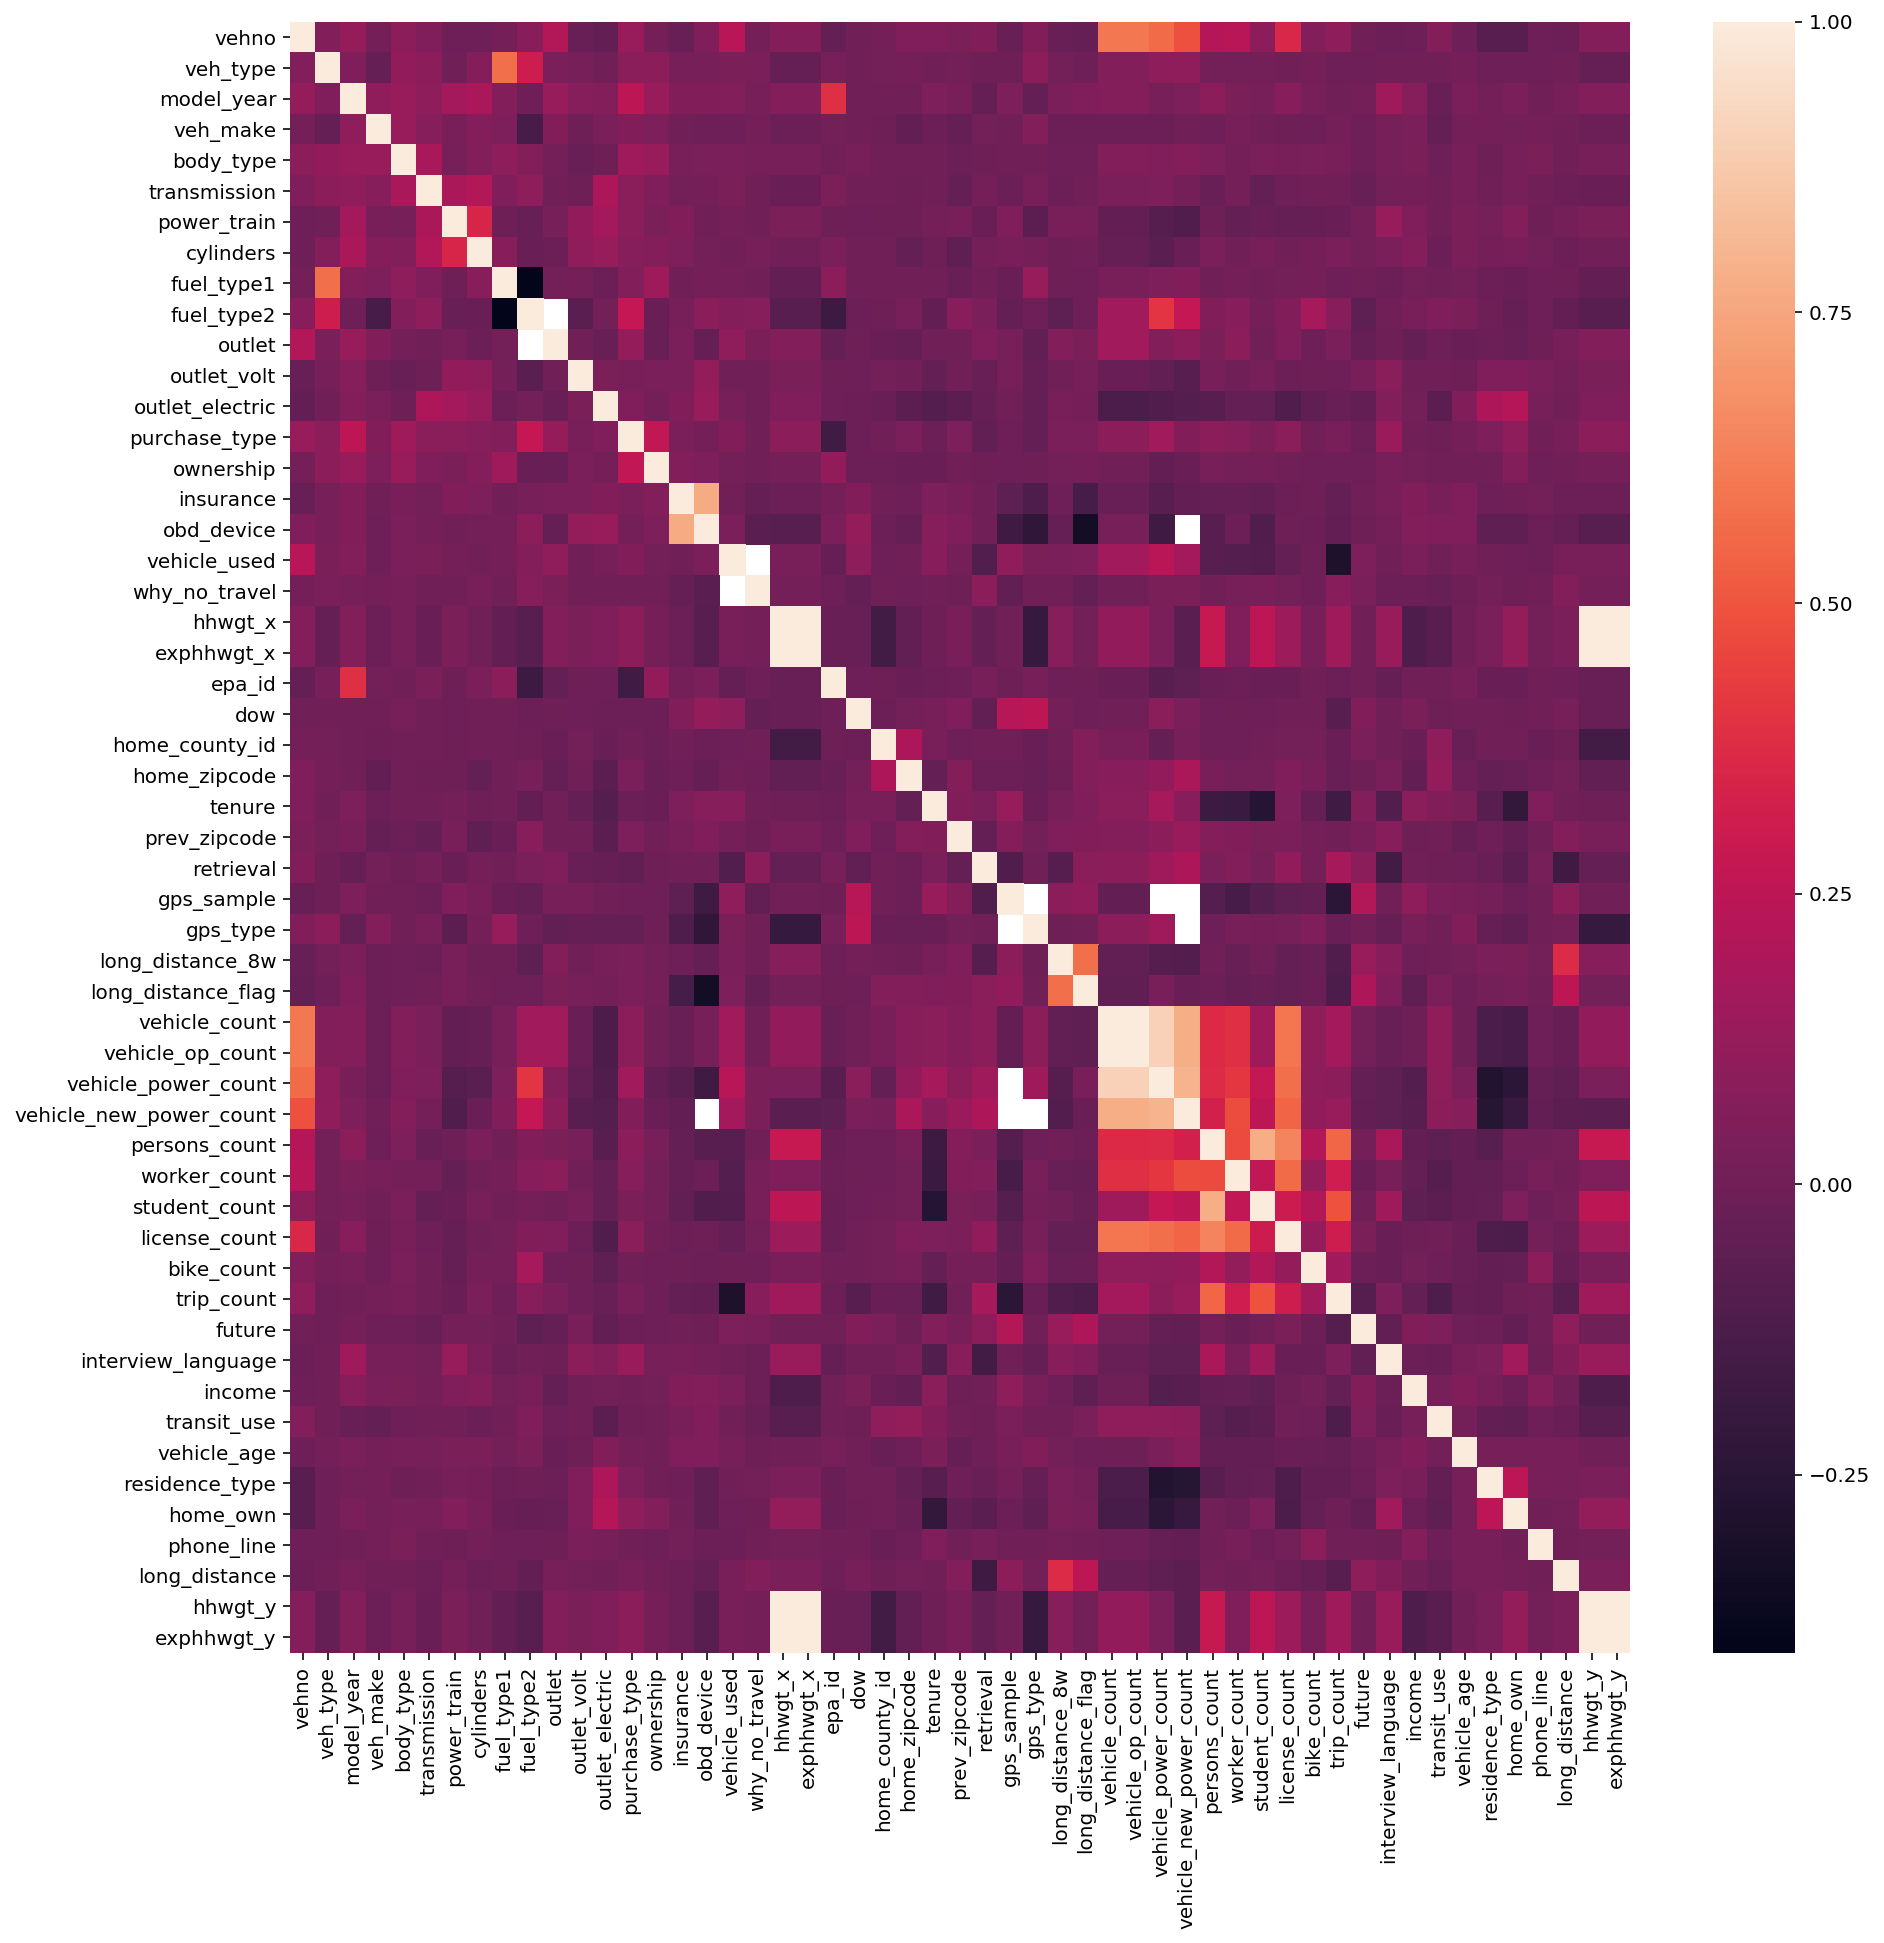

In [49]:
# correlation matrix of the trimmed household and vehicle set
fig, axes = plt.subplots(figsize=(15,15))
corrs = df_survey_hous_veh_ba.corr()
sns.heatmap(corrs, 
        xticklabels=corrs.columns,
        yticklabels=corrs.columns);

### Build Preprocessed Dataset
[Top](#Table-of-Contents)

In [46]:
# Filtering data for only the bay area
households_ba = df_survey_households[df_survey_households.home_county_id.isin([1, 13, 41, 55, 75, 81, 85, 95, 97])]
places_ba = df_survey_places[df_survey_places.sampno.isin(households_ba.sampno)]
persons_ba = df_survey_persons[df_survey_persons.sampno.isin(households_ba.sampno)]
vehicles_ba = df_survey_vehicles[df_survey_vehicles.sampno.isin(households_ba.sampno)]

In [47]:
#find the top 25 various travel modes with their descriptions:
"""FROM DATA DICTIONARY
Travel mode:
1- Walk;
2- Bike;
3- Wheelchair/mobility scooter;
4- Other non-motorized;
5- Auto/van/truck driver;
6- Auto/van/truck passenger;
7- Carpool/vanpool;
8- Motorcycle/scooter/moped;
9- Taxi/hired car/limo;
10- Rental car/vehicle;
11- Private shuttle (Super shuttle, employer, hotel, etc.);
12- Greyhound bus;
13- Plane;
14- Other private transit;
15- Local bus, rapid bus;
16- Express bus/commuter bus (AC Transbay, Golden Gate Transit, etc.);
17- Premium bus (Metro Orange/Silver Line);
18- School bus;
19- Public transit shuttle (DASH, Emery Go Round, etc.);
20- AirBART/LAX FlyAway;
21- Dial-a-ride/paratransit (access services, etc.);
22- Amtrak bus;
23- Other bus;
24- BART, Metro Red/Purple Line;
25- ACE, Amtrak, Cal- train, Coaster, Metrolink;
26- Metro Blue/Green/Gold Line, Muni Metro, Sacramento Light Rail, San Diego Sprinter/Trolley/Orange/ Blue/Green, VTA light rail;
27- Streetcar/cable car,
28- Other rail;
29- Ferry/boat;
99- RF
"""
print("modes of transit = \n{}".format(places_ba['mode'].value_counts().head(25)))



#find the top 25 various vehicle types:
"""
Vehicle type: 1- Hybrid vehicle;
2- Gasoline-only vehicle;
3- Diesel-only vehicle;
4- Plug-in hybrid electric vehicle;
5- CNG,
6- Electric only;
7- Other;
9- DK/RF
"""
print("within cars, type of vehicle = \n{}".format(vehicles_ba['veh_type'].value_counts().head(25)))


modes of transit = 
5.0     50139
6.0     18632
1.0     15924
2.0      2244
15.0     1635
24.0     1444
7.0       566
26.0      459
8.0       299
25.0      293
18.0      276
11.0      243
10.0      199
13.0      177
16.0      164
9.0       151
4.0       112
14.0      104
29.0       66
27.0       65
28.0       58
3.0        52
19.0       41
21.0       32
23.0       22
Name: mode, dtype: int64
within cars, type of vehicle = 
2    15799
1     1145
3      342
6       94
7       54
4       42
5       20
9        1
Name: veh_type, dtype: int64


We can see that the bulk of all transit being taken is by auto/van/truck driving, and within that, the bulk of the auto/van/trucks are gasoline-only vehicles.

In [63]:
#Trimming datasets

#remove irrelevant columns from households for our analysis
unnecessary_columns = ['recruite', 'incentive', 'sample_type', 'cec_sample', 'non_relative_flag',
                       'strata', 'mpo_sample', 'mtc_finalflag','buyer1', 'home_state_id',
                       'buyer2', 'buyer3', 'buyer4', 'buyer5', 'buyer6', 'buyer7', 'buyer8',
                       'ldper1', 'ldper2', 'ldper3', 'ldper4', 'ldper5', 'ldper6', 'ldper7',
                       'noveh3', 'noveh4', 'noveh5', 'noveh6', 'noveh7', 'noveh8', 'gps_mtc',
                       'ldper8', 'hhwgt', 'exphhwgt', 'geom', 'complete_all', 'complete_gps',
                        'hispanic_flag', 'assn', 'recruite_date', 'home_block_id',
                       'home_tract_id']
trimmed_households = households_ba.drop(unnecessary_columns, axis=1)
print(trimmed_households.columns)
print(trimmed_households.shape)

print("**********")
#remove irrelevant columns from persons dataset for our analysis
unnecessary_columns = ['nrel_agebin', 'education_other', 'has_diary', 'race3', 'race4', 'race_other',
                       'transit_pass_t3', 'transit_pass_t4', 'transit_pass_t5', 'transit_pass_t6', 'transit_pass_t7',
                       'transit_pass_other', 'clipper_card_t1', 'clipper_card_t2', 'clipper_card_t3', 'compass_card',
                       'typs_ex_pass_card', 'empl_status_other', 'empl_industry_other', 'empl_occupation_other',
                       'empl_name', 'empl_state', 'empl_cross_street1', 'empl_cross_street2', 'empl_block_id',
                       'empl_tract_id', 'empl_state_id', 'empl_county_id', 'empl_lon', 'empl_lat', 'workday_mon',
                       'workday_tue', 'workday_wed', 'workday_thurs', 'workday_fri', 'workday_sat', 'workday_sun',
                       'workday_flex', 'workday_flex_opt', 'empl_sec_loc', 'empl_sec_name', 'empl_sec_city',
                       'empl_sec_zipcode', 'empl_sec_state', 'empl_sec_state_id', 'empl_sec_primarycity',
                       'empl_sec_cross_street1', 'empl_sec_cross_street2', 'workday_sec_count', 'dis_type3',
                       'dis_type4', 'dis_type5', 'dis_type6', 'dis_type7', 'dis_other', 'dis_lis_plate', 'dis_reg',
                       'school_grade_other', 'school_home', 'school_pre', 'school_pre_other', 'school_name',
                       'school_city', 'school_zipcode', 'school_state', 'school_cross_street1', 'school_cross_street2',
                       'school_block_id', 'school_tract_id', 'school_county_id', 'school_state_id', 'school_primarycity',
                       'school_lon', 'school_lat', 'transit_subsidy', 'transit_subsidy_amt', 'transit_subsidy_unit',
                       'transit_subsidy_unit_other', 'interview', 'interview_proxy', 'interview_log_complete',
                       'toll_road3', 'toll_road4', 'toll_road5', 'toll_road6', 'toll_road7', 'toll_road8',
                       'toll_road9', 'toll_road10', 'toll_bridge3', 'toll_bridge4', 'toll_bridge5', 'toll_bridge6',
                       'toll_bridge7', 'toll_bridge8', 'toll_bridge9', 'toll_bridge10', 'why_no_trips_other',
                       'incomplete', 'perwgt', 'expperwgt', 'geom', 'hispanic_flag']
trimmed_persons = persons_ba.drop(unnecessary_columns, axis=1)
print(trimmed_persons.columns)
print(trimmed_persons.shape)
print("*****************")

#remove irrelevant columns from places dataset for our analysis
unnecessary_columns = ['tripno', 'air_trip_distance_miles', 'tripdistanceflag', 'block_id', 'tract_id',
                       'state_id', 'parked_other_loc_type', 'parked_address', 'parked_unit', 'parked_other_pay_type',
                       'parked_paymen_ne', 'got_out_vehicle', 'transit_system_other', 'perwgt', 'expperwgt',
                       'tcf', 'tcfperwgt', 'exptcfperwgt', 'lon', 'lat', 'route', 'per1', 'per2', 'per3', 'per4',
                       'per5', 'geom', 'perno', 'vehno', 'travel_date']

trimmed_places = places_ba.drop(unnecessary_columns, axis=1)
print(trimmed_places.columns)
print(trimmed_places.shape)
print("***************")


#remove irrelevant columns from vehicles dataset for our analysis
unnecessary_columns = ['vehno', 'veh_series', 'veh_series_other', 'fuel_type2', 'fuel_type3', 'fuel_type4',
                       'fuel_type5', 'fuel_type6', 'fuel_type_other', 'outlet', 'outlet_volt', 'insurance',
                       'outlet_electric', 'obd_device', 'hhwgt', 'exphhwgt', 'geom', 'why_no_travel',
                       'why_no_travel_other']

trimmed_vehicles = vehicles_ba.drop(unnecessary_columns, axis=1)
print(trimmed_vehicles.columns)
print(trimmed_vehicles.shape)

Index(['sampno', 'dow', 'home_county_id', 'home_primarycity', 'home_city',
       'home_state', 'home_zipcode', 'home_lon', 'home_lat', 'tenure',
       'prev_city', 'prev_state', 'prev_zipcode', 'retrieval', 'gps_sample',
       'gps_type', 'long_distance_8w', 'long_distance_flag', 'vehicle_count',
       'vehicle_op_count', 'vehicle_power_count', 'vehicle_new_power_count',
       'persons_count', 'worker_count', 'student_count', 'license_count',
       'bike_count', 'trip_count', 'future', 'interview_language', 'income',
       'transit_use', 'vehicle_age', 'residence_type', 'residence_type_other',
       'home_own', 'home_own_other', 'phone_line', 'long_distance', 'noveh1',
       'noveh2'],
      dtype='object')
(9715, 41)
**********
Index(['sampno', 'perno', 'vehno', 'travel_date', 'relation', 'gender', 'age',
       'education', 'person_trips', 'walk_trips', 'bike_trips', 'motor_trip',
       'race1', 'race2', 'citizen', 'country_birth', 'driver_license',
       'transit_pass', '

In [66]:
#merging persons, vehicles and households datasets
df_survey_hous_per = pd.merge(trimmed_households, trimmed_persons, on='sampno', how='left')
df_survey_hous_veh = pd.merge(trimmed_households, trimmed_vehicles, on='sampno', how='left')
# df_survey_hous_pla = pd.merge(trimmed_households, trimmed_places, on='sampno', how='left')
df_merged = pd.merge(df_survey_hous_per, df_survey_hous_veh, on='sampno', how='left')
# df_merged = pd.merge(df_merged, df_survey_hous_pla, on='sampno', how='left')

In [67]:
df_merged.shape


(49421, 147)

In [194]:
def preprocess_data(df, column_subset=None):
    ''' Returns a preprocessed dataset. Possible preprocessing steps include:
     - getting a subset of the data
     - filling NaNs with zero, or some other value like the median of the data
     - scaling the data (z-score, etc.)
    
    Parms:
        df - the input data
        columns_subset - an optional subset of columns
    
    Returns:
        df_new - the output dataset
    '''
    df_new = df.copy()
    if column_subset:
        df_new = get_subset(df_new, column_subset)
    df_new = nans_fill_zero(df_new)
    return df_new

In [195]:
df_hous_veh_subset = preprocess_data(df_survey_hous_veh, 
                                     column_subset=['veh_type', 'worker_count', 'student_count'])

In [68]:
df_merged.isnull().sum()

sampno                           0
dow_x                            0
home_county_id_x                 0
home_primarycity_x               0
home_city_x                      0
home_state_x                     0
home_zipcode_x                   0
home_lon_x                       0
home_lat_x                       0
tenure_x                         0
prev_city_x                  40003
prev_state_x                 40037
prev_zipcode_x               40001
retrieval_x                      0
gps_sample_x                     0
gps_type_x                   22750
long_distance_8w_x               0
long_distance_flag_x         30275
vehicle_count_x                  0
vehicle_op_count_x             781
vehicle_power_count_x        46902
vehicle_new_power_count_x    47401
persons_count_x                  0
worker_count_x                   0
student_count_x                  0
license_count_x                  0
bike_count_x                     0
trip_count_x                     0
future_x            

In [72]:
#get the numerical columns to replace NaN values

#fill in all rows that contain NaNs
df_merged = df_merged.fillna(lambda x: x.median())
df_merged.isnull().sum()

sampno                       0
dow_x                        0
home_county_id_x             0
home_primarycity_x           0
home_city_x                  0
home_state_x                 0
home_zipcode_x               0
home_lon_x                   0
home_lat_x                   0
tenure_x                     0
prev_city_x                  0
prev_state_x                 0
prev_zipcode_x               0
retrieval_x                  0
gps_sample_x                 0
gps_type_x                   0
long_distance_8w_x           0
long_distance_flag_x         0
vehicle_count_x              0
vehicle_op_count_x           0
vehicle_power_count_x        0
vehicle_new_power_count_x    0
persons_count_x              0
worker_count_x               0
student_count_x              0
license_count_x              0
bike_count_x                 0
trip_count_x                 0
future_x                     0
interview_language_x         0
                            ..
interview_language_y         0
income_y

# Feature Extraction
[Top](#Table-of-Contents)

In [196]:
def expand_veh_type(df):
    ''' 
    Expanding the vehicle types into one-hot-vectors. Not really a feature, just helpful to read.
    '''
    df_new = df.copy()
    if 'veh_type' not in df.columns:
        print('Error: Vehicle type is not in the columns. Check if you dropped it already.')
        return
    
    # Create new columns based on discrete values
    veh_type_vecs = pd.get_dummies(df['veh_type'])
    
    # Add string column names
    veh_type_num_to_name = {
        1:'Hybrid', 2: 'Gasoline-only', 3:'Diesel-only',
        4:'Plug-in Hybrid Electric', 5:'CNG', 6:'Electric Only',
        7:'Other',9:'DK/RF'
    }
    column_names = [veh_type_num_to_name[num] for num in veh_type_vecs.columns]
    
    # Add these columns to the dataframe
    df_new[column_names] = veh_type_vecs
    
    # Drop the original columns
    df_new = df_new.drop('veh_type', axis=1, inplace=False)
    
    return df_new

def add_household_weight(df, df_full):
    df_new = df.copy()
    df_new['household_weight'] = df_full['hhwgt_y']
    return df_new

## Put more feature functions here...

### Build Features
[Top](#Table-of-Contents)

In [326]:
## Unused for now
def get_features(df, label):
    df_features = df.copy()
    df_features = df_features.drop(label, axis=1)
    return df_features
    
def get_labels(df, label):
    return pd.DataFrame(df[label])

def partition_data(features, labels):
    return train_test_split(features, labels, 
                           test_size=0.3,
                           random_state=789)
##

def build_features(df, df_full):
    ''' Build the final features dataframe
    
    Parms:
        df - the subsetted dataset
        df_full - the original dataset with all the columns
    Returns:
        df_features - the features dataframe
        df_target - the labels Series
    '''
    # Get and Store Labels
    df_target = df['veh_type'].copy()
    # Drop label from original df
    df = df.drop('veh_type', inplace=False, axis=1)
    
    # Get features from original dataset
    df_features = add_household_weight(df, df_full)  
    df_features = nans_fill_zero(df_features)
    
    return df_features, df_target

In [327]:
df_features, df_target = build_features(df_hous_veh_subset, df_survey_hous_veh)

In [328]:
train_features, test_features, train_labels, test_labels = train_test_split(df_features,
                                                                         df_target,
                                                                         test_size=0.3,
                                                                         random_state=789)

**Sanity check that there are no remaining null values**

In [329]:
df_features.isnull().sum()

worker_count        0
student_count       0
household_weight    0
dtype: int64

### Baseline Models
[Top](#Table-of-Contents)

In [201]:
# all_features = get_features(df, 'put_label_name_here')
# all_labels = get_labels(df, 'put_label_name_here')
# train_features, test_features, train_labels, test_labels = partition_data(all_features, all_labels)
# train_labels = np.ravel(train_labels)
# test_labels = np.ravel(test_labels)

In [330]:
def train_and_test_model(model):
    print()
    print(model)
    print()
    print('Training model...')
    fitted = model.fit(train_features, train_labels)
    print('Test the model.')
    predicted = fitted.predict(test_features)
    predicted_classes = predicted.round()
    # My Model predicted all two's
    non_gas = [x for x in predicted_classes if x !=2]
    if len(non_gas) > 0:
        print('\nPredicted some non-gasoline cars.\n')
        ## Optionally uncomment below to print the non-gas predicted cars
        #print(non_gas)
    else:
        print('\nOnly gas cars predicted. Same as baseline prediction.\n')
    accuracy = accuracy_score(predicted_classes, test_labels)
    fscore = f1_score(predicted_classes, test_labels, average='weighted')
    print('This model\'s accuracy is {}'.format(accuracy))
    print('This model\'s f1 score is {}'.format(fscore))
    return predicted, accuracy

def get_predictions_and_scores(all_models):
    '''
    Store the predictions and scores in a list of tuples, that can be sorted based on a key. The key is the
    accuracy of each model.
    
    Returns the highest score and corresponding prediction of labels.
    '''
    predictions_and_accuracies = [train_and_test_model(model) for model in all_models]
    return max(predictions_and_accuracies, key=lambda x: x[1])

In [331]:
pipeline = Pipeline([('clf', DecisionTreeClassifier())])

In [332]:
all_models = [LinearRegression(), LogisticRegression(), BernoulliNB(), pipeline]
max_score_for_prediction = get_predictions_and_scores(all_models)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Training model...
Test the model.

Only gas cars predicted. Same as baseline prediction.

This model's accuracy is 0.9197181910226122
This model's f1 score is 0.9581804197340952

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Training model...


/Users/vikram/anaconda/envs/dsji/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Test the model.

Only gas cars predicted. Same as baseline prediction.

This model's accuracy is 0.9197181910226122
This model's f1 score is 0.9581804197340952

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

Training model...
Test the model.

Only gas cars predicted. Same as baseline prediction.

This model's accuracy is 0.9197181910226122
This model's f1 score is 0.9581804197340952

Pipeline(steps=[('clf', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))])

Training model...
Test the model.

Predicted some non-gasoline cars.

This model's accuracy is 0.8938997637529531
This model's f1 score is 0.9135382149305129


/Users/vikram/anaconda/envs/dsji/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/vikram/anaconda/envs/dsji/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [333]:
print('The best model has a score of {:.2f} percent.'.format(max_score_for_prediction[1]*100))

The best model has a score of 91.97 percent.


In [78]:
#Creating train and test for the variables
cols = df_merged.columns
num_cols = df_merged._get_numeric_data().columns #find columns with numerical data
list_cols = list(set(cols) - set(num_cols))
#print(list_cols)

#set up the X and y datasets for train/test splits
X = df_merged[num_cols]
y = df_merged['veh_type']

#split training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


0                                         4
1                                         2
2        <function <lambda> at 0x126f5aea0>
3        <function <lambda> at 0x126f5aea0>
4        <function <lambda> at 0x126f5aea0>
5                                         2
6                                         2
7                                         2
8                                         2
9                                         2
10                                        2
11                                        2
12                                        2
13                                        2
14                                        2
15                                        2
16                                        2
17                                        2
18                                        2
19                                        2
20                                        2
21                                        2
22       <function <lambda> at 0

## Change the Baseline
[Top](#Table-of-Contents)

In [334]:
df_dummy_veh_type = expand_veh_type(df_train_label)

In [335]:
df_dummy_veh_type.sum()

Hybrid                      2282
Gasoline-only              50817
Diesel-only                 1668
Plug-in Hybrid Electric       84
CNG                           55
Electric Only                187
Other                        205
DK/RF                          9
dtype: int64

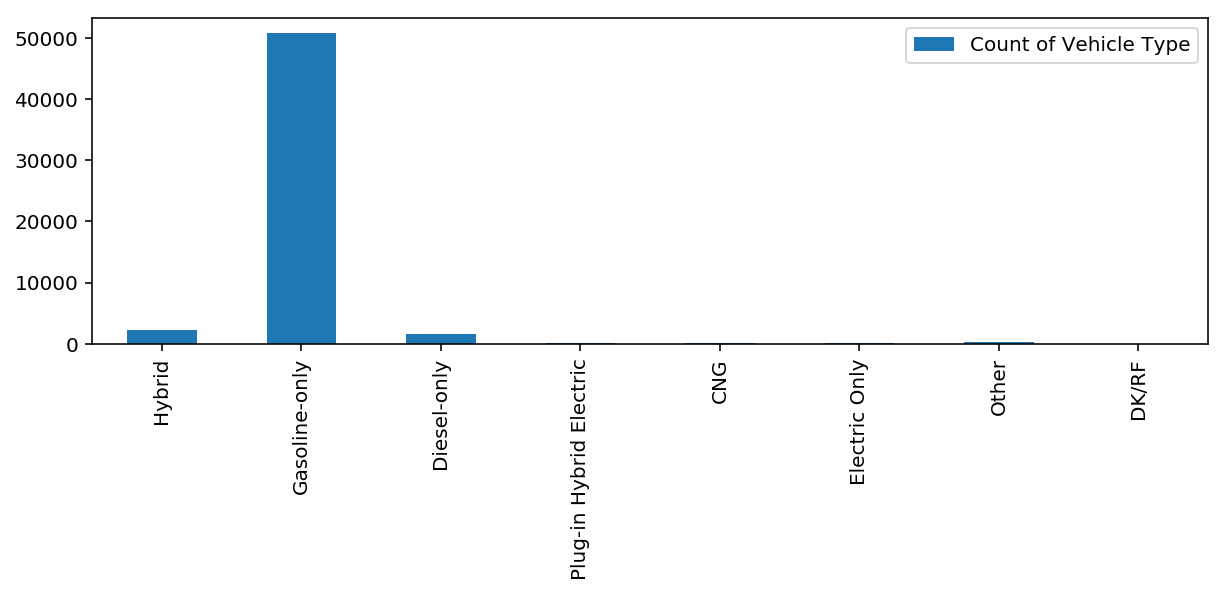

In [336]:
pd.DataFrame(df_dummy_veh_type.sum(), columns=['Count of Vehicle Type']).plot(kind='bar', figsize=(10,3));

**Predict all gasoline cars as the baseline.**

In [337]:
baseline_predictions = [2 for x in range(len(test_labels))]
print('Baseline Accuracy: {}'.format(accuracy_score(baseline_predictions, test_labels)))
print('Baseline F1-Score: {}'.format(f1_score(baseline_predictions, test_labels, average='weighted')))

Baseline Accuracy: 0.9197181910226122
Baseline F1-Score: 0.9581804197340952


/Users/vikram/anaconda/envs/dsji/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## Error Analysis
[Top](#Table-of-Contents)

I will plot a confusion matrix to show how many false positives, false negatives, true positives, and true negative I classified using my model.

## kNN 

In [77]:
#initialize knn classifier model (k = 5)
knn = KNeighborsClassifier(n_neighbors=5)

# fit the model
knn.fit(X_train, y_train)

# predict the target values
pred = knn.predict(X_test)

# evaluate its accuracy
print(accuracy_score(y_test, pred))



ValueError: Unknown label type: 'unknown'

## Decision Trees
[Top](#Table-of-Contents)

In [301]:
def run_model(model):
    print()
    print('Training the model (Fitting to the training data) ')
    fitted = model.fit(train_features, train_labels)
    print('Fitted model: {}'.format(fitted))
    print('Test the model.')
    predicted = fitted.predict(test_features)
    predicted_classes = predicted.round()
    # My Model predicted all two's
    non_gas = [x for x in predicted_classes if x !=2]
    if len(non_gas) > 0:
        print('\nPredicted some non-gasoline cars. {}\n'.format(non_gas))
    else:
        print('\nOnly gas cars predicted. Same as baseline prediction.\n')
    accuracy = accuracy_score(predicted_classes, test_labels)
    fscore = f1_score(predicted_classes, test_labels, average='weighted')
    print('This model\'s accuracy is {}'.format(accuracy))
    print('This model\'s f1 score is {}'.format(fscore))
    return fitted

def decision_tree(leaf_nodes=10):
    return run_model(DecisionTreeClassifier(max_leaf_nodes=leaf_nodes))

In [302]:
dt_classifier = decision_tree()


Training the model (Fitting to the training data) 
Fitted model: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=10, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Test the model.

Predicted some non-gasoline cars. [3, 3, 3, 3]

This model's accuracy is 0.9195494431319609
This model's f1 score is 0.9579271577427956


/Users/vikram/anaconda/envs/dsji/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [303]:
df_features.columns

Index(['worker_count', 'student_count', 'household_weight'], dtype='object')

In [306]:
feature_names = df_features.columns
label_names = pd.DataFrame(df_target, columns=['veh_type']).columns
dot_data = export_graphviz(dt_classifier, out_file=None,
               feature_names=feature_names,
               # Below are the Vehicle Type classes
               class_names=['Hybrid','Gas-Only','Diesel-Only','Plug-in Hybrid','CNG',
                            'Electric-Only','Other','DK/RF'],
               filled=True, rounded=True,
               special_characters=False)
graph = pydotplus.graph_from_dot_data(dot_data)

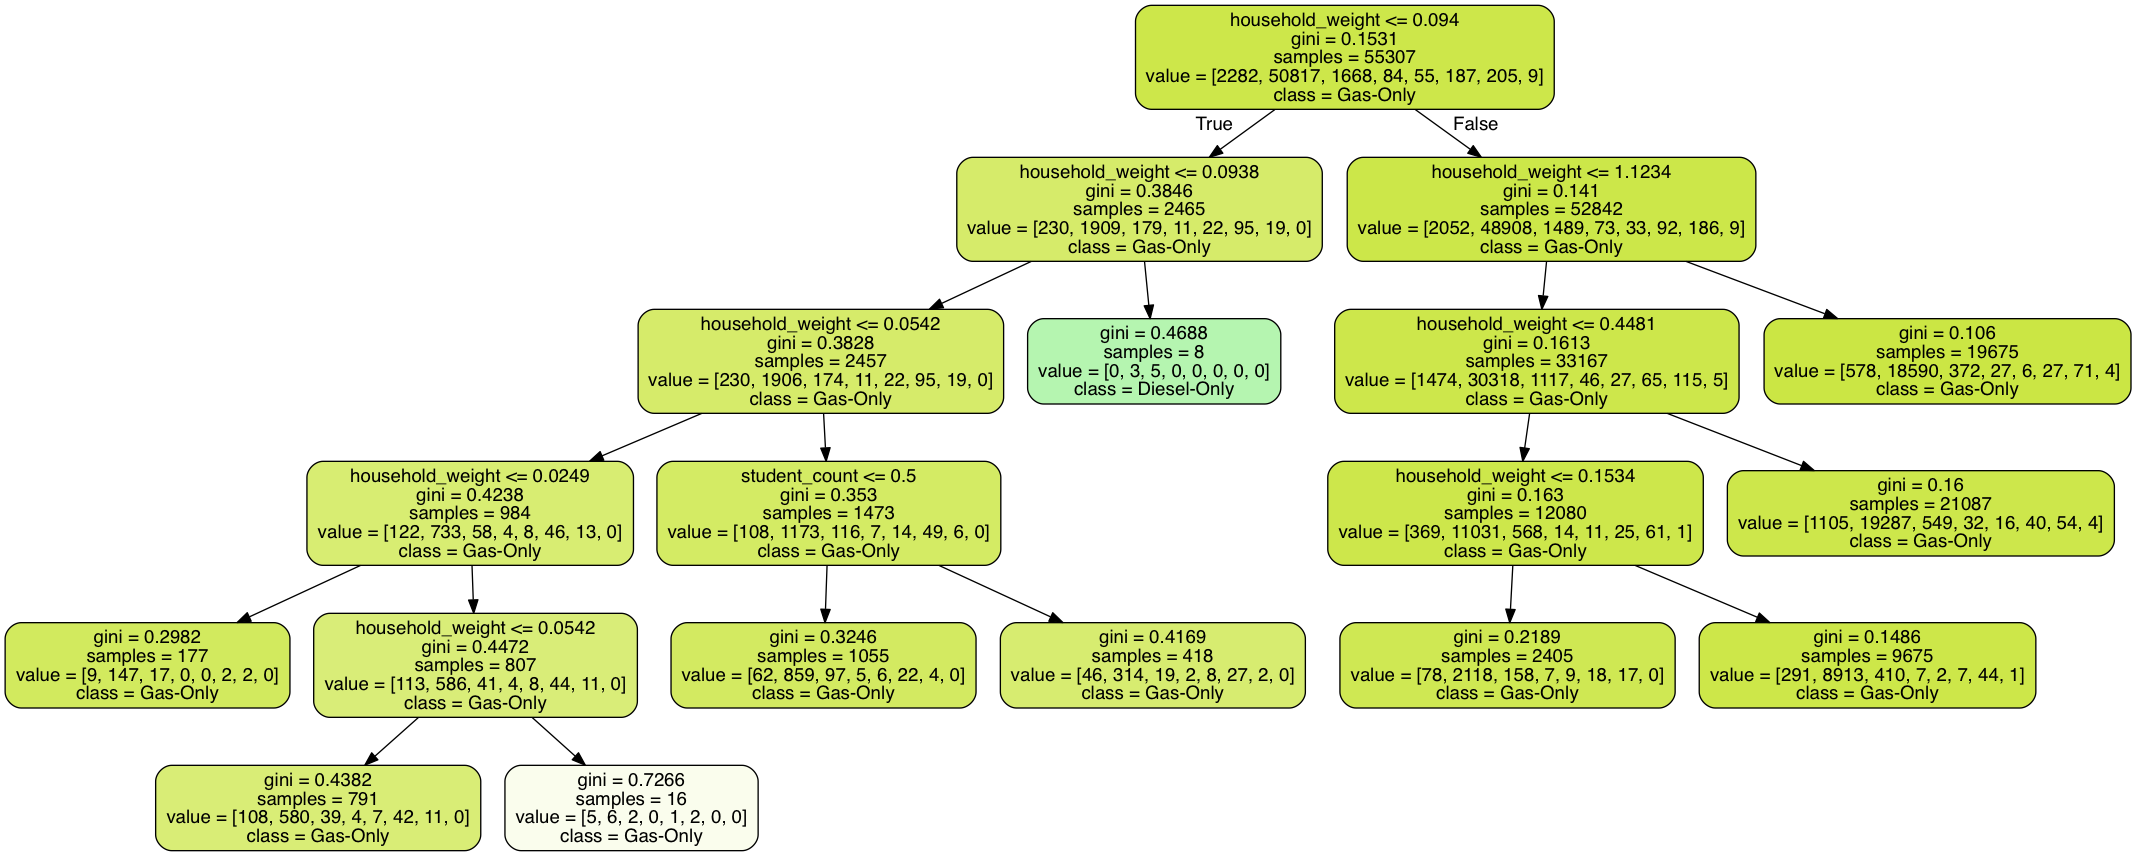

In [307]:
Image(graph.create_png())

**Random Forest**

In [308]:
run_model(RandomForestClassifier(
    n_estimators=100, max_leaf_nodes=20)
    );


Training the model (Fitting to the training data) 
Fitted model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=20,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Test the model.

Only gas cars predicted. Same as baseline prediction.

This model's accuracy is 0.9197181910226122
This model's f1 score is 0.9581804197340952


/Users/vikram/anaconda/envs/dsji/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## Summary
[Top](#Table-of-Contents)